# Решение тестового задания: Декодировщик.

In [ ]:
# Стандартные библиотеки Python
import os
import random

# Библиотеки для работы с данными
import numpy as np
import pandas as pd

# Библиотеки для обработки аудио
import librosa
from scipy import signal
from scipy.io.wavfile import write

# Визуализация
import matplotlib.pyplot as plt

# PyTorch и связанные модули
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split

# Прогресс-бар
from tqdm import tqdm

# Аугментация
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, PitchShift, Gain, Shift, BandPassFilter, ClippingDistortion, TimeMask

In [44]:
def open_file(path, sr=32000):
    """
    Принимает путь к аудио файлу, открывает его при помощи librosa
    Args:
        path (str):  путь к файлу.
        sr (int): Частота дескрицизаци
    Returns:
        y (np.ndarray): Загруженный аудиосигнал в виде одномерного массива.
        sr: частота десрицизации 
    """
    file_path = path
    # Загружаем звук, приводим к 32kHz
    y, sr = librosa.load(file_path, sr=sr)

    # file_name = path.split('/')[-1]
    # Проверим длительность
    # print(f"Имя файла: {file_name}")
    # print(f"Длительность: {len(y) / sr:.2f} сек, Частота: {sr} Гц")
    return y, sr


def get_mell(y, sr):
    """
    Вычисляет мел-спектрограмму из аудиосигнала и преобразует её.
    Args:
        y (np.ndarray): Аудиосигнал.
        sr (int): Частота дискретизации аудиосигнала.
    Returns:
        S_dB (np.ndarray): Мел-спектрограмма в децибелах (логарифмическая шкала).
    """
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB


def draw_mell(S_dB, sr):
    """
    Визуализирует мел-спектрограмму с использованием библиотеки librosa.
    Args:
        S_dB (np.ndarray): Мел-спектрограмма в децибелах (логарифмическая шкала).
        sr (int): Частота дискретизации аудиосигнала.
    Returns:
        None: Функция отображает график, но не возвращает данных.
    """
    # Отрисовка
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram (denoised)')
    plt.tight_layout()
    plt.show()

также пробовал torchaudio.transforms.MelSpectrogram, но они мне понравились меньше

##### Далее были предприняты, попытки очистить сигнал от шума при помощи:
- Полосовой фильтрации
- Адаптивного подавления шума с использованием спектрального вычитания
- Извлечение огибающей сигнала
- Адаптивного порогового значения
- Морфологической фильтрации
- Комперссии

Пример для 31.opus:
![image](output.png)

По итогу сравнивая модель до обработки и после, результат был всегда лучше без этих обработок. Пробовал и полоное обучение на обработанных данные, так и файнтюн.

data/morse_dataset/morse_dataset/1.opus


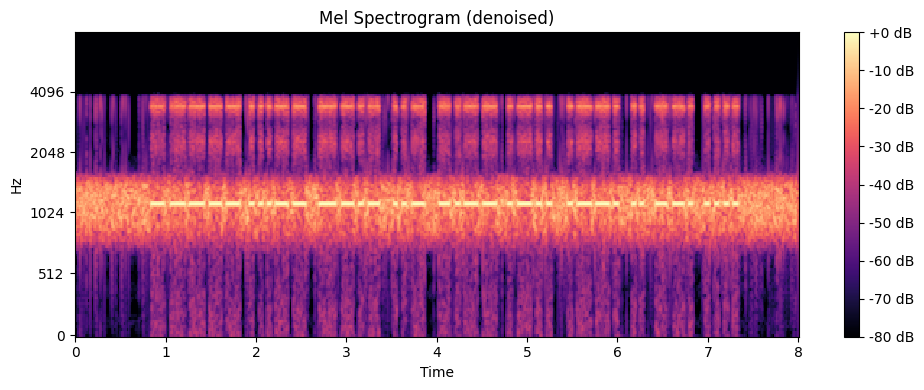

data/morse_dataset/morse_dataset/2.opus


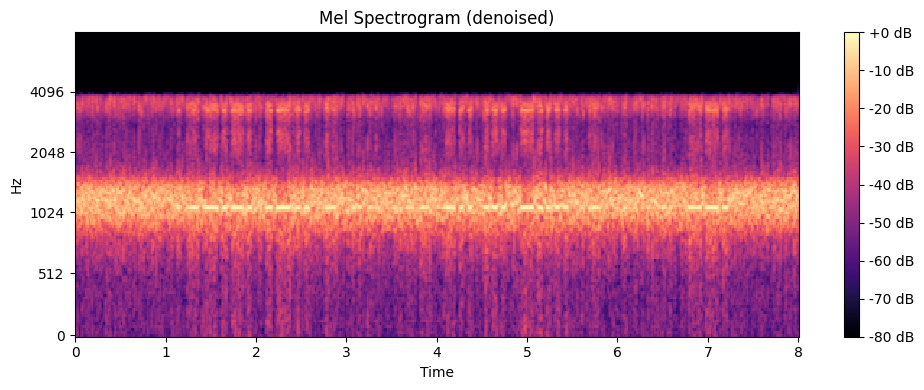

data/morse_dataset/morse_dataset/3.opus


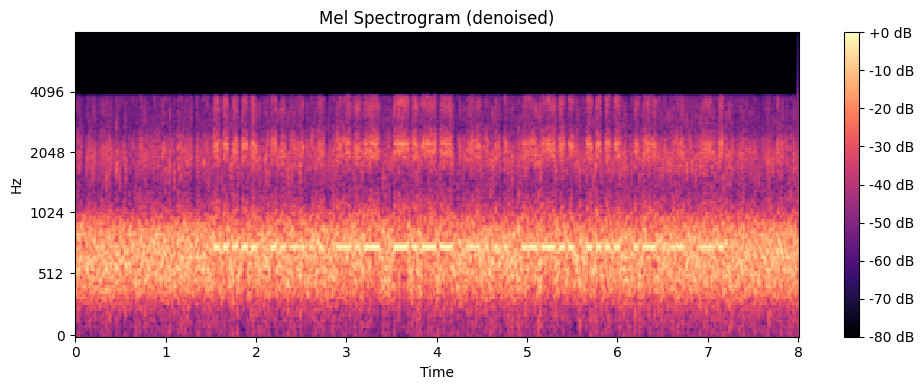

data/morse_dataset/morse_dataset/4.opus


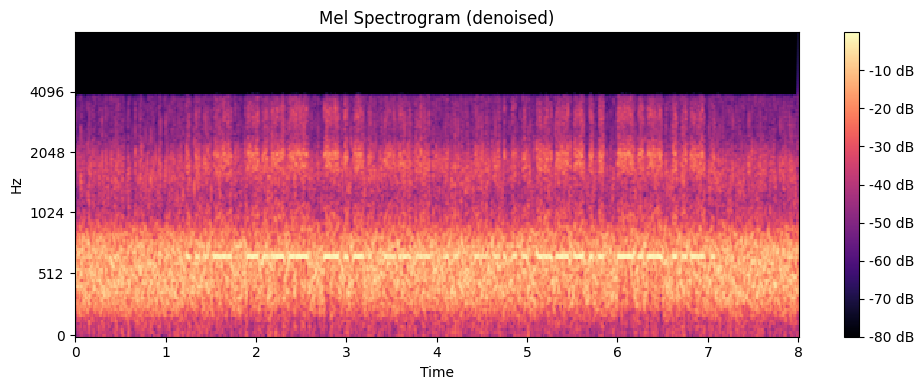

In [45]:
def path_to_files_from_n_to_m(n, m, base_path="data/morse_dataset/morse_dataset/"):
    """
    Просто удобная для меня функция, которая вернёт список путей от n до m.
    Работает при условиях:
    - Все аудио файлы лежат в base_path
    - Имяют названия 1.opus, 2.opus и т.д
    Args:
        n, m (int): Индекс начала и конца файлов.
        base_path (str): адрес директории, где лежат файлы
    returns:
        paths (List[str]): Список путей к фалайм в base_path 
    """
    paths = list()
    for i in range(n, m):
        paths.append(base_path + str(i) + ".opus")
    return paths

# вызов написанных функций
for i in path_to_files_from_n_to_m(1, 5):
    print(i)
    y, sr = open_file(i)
    S_db = get_mell(y, sr)
    
    # r = process_morse_audio(i, visualize=False)
    # S_db = r['spectrogram']
    # sr = r['sr']
    draw_mell(S_db, sr)

In [46]:
train_df = pd.read_csv('data/train.csv')
train_df.head(5)
train_df.loc[0:3]

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ


После визауального осмотра, начал думать как решать задачу, варианты были следующими:
- CNN + FC 
- CNN + BiLSTM
- Файнтюн какой нибудь модели для речи, например Wav2Vec2.

Кроме всего этого важно было выбрать loss.
- Лучшим вариантом показался CTC Loss

In [47]:
# Определяем алфавит для CTC Loss:
# - Русские буквы (33 символа).
# - Цифры (10 символов).
# - Дополнительные символы: пробел (' ') и специальный символ '#'.
# Для CTC Loss также требуется <blank> символ, который используется для обозначения пустого токена.
RUSSIAN_CHARS = list("АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ")  # 33
DIGITS = list("0123456789")  # 10
EXTRA = [' ', '#']  
ALL_CHARS = RUSSIAN_CHARS + DIGITS + EXTRA

CHAR_TO_INDEX = {c: i + 1 for i, c in enumerate(ALL_CHARS)}
CHAR_TO_INDEX['<blank>'] = 0
INDEX_TO_CHAR = {i: c for c, i in CHAR_TO_INDEX.items()}
print(CHAR_TO_INDEX['<blank>'])
print(INDEX_TO_CHAR[0])

0
<blank>


In [48]:
# Создание класса Датасета
# Как я описывал ваше, по экспериментам, лучше всего учить модель без обработок
class MorseDataset(Dataset):
    def __init__(self, df: pd.DataFrame, audio_dir: str):
        self.df = df
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = f"{self.audio_dir}/{row['id']}"

        # # === Вариант с torchaudio ===
        # waveform, sr = torchaudio.load(file_path)  # [1, time]
        # if sr != self.sample_rate:
        #     resampler = T.Resample(sr, self.sample_rate)
        #     waveform = resampler(waveform)

        # S = self.mel_transform(waveform)  # [1, n_mels, time]
        # S_dB = self.db_transform(S).squeeze(0)  # [n_mels, time]

        # # Нормализация
        # S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
        # spectrogram = S_dB.unsqueeze(0)  # [1, n_mels, time]

        # === вариант без torchaudio ===
        y, sr = open_file(file_path)
        S_dB = torch.from_numpy(get_mell(y, sr))  # (n_mels, time)
        S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
        spectrogram = S_dB.unsqueeze(0)  # (1, n_mels, time)

        # === С обработкой ===
        # r = process_morse_audio(file_path, visualize=False)
        # S_dB = torch.from_numpy(r['spectrogram']).float()
        # S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
        # spectrogram = S_dB.unsqueeze(0)  # (1, n_mels, time)

        # Текст в индекс
        message = row['message'].strip().upper()
        label = [CHAR_TO_INDEX[c] for c in message if c in CHAR_TO_INDEX]

        return spectrogram, torch.tensor(label, dtype=torch.long)


In [49]:
def collate_fn(batch):
    """
    Функция для обработки батча данных, необходимая для использования с CTC Loss.
    Выполняет паддинг спектрограмм и меток, а также вычисляет их длины.
    """
    spectrograms = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Вычисляем длины исходных спектрограмм
    input_lengths = torch.tensor([spec.shape[2] for spec in spectrograms], dtype=torch.long)
    
    # Паддинг спектрограмм
    spectrograms = torch.nn.utils.rnn.pad_sequence(
        spectrograms,
        batch_first=True,
        padding_value=0
    )
    
    # Паддинг меток
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    labels = torch.nn.utils.rnn.pad_sequence(
        labels,
        batch_first=True,
        padding_value=-1
    )
    
    return spectrograms, labels, input_lengths, label_lengths

 Также чтобы улучшить модель, под конец решил пропробовать сделать свой генератор похожих сигналов, и выполнить аугментации данных

По итогу, от обоих подходов был прирост в метрике

### Генератор

In [ ]:
os.makedirs("morse_data", exist_ok=True)
os.makedirs("morse_data/audio", exist_ok=True)

SAMPLE_FREQ = 8192  
DURATION_SEC = 8    

MORSE_CODE_DICT = {
    "А": ".-",     "Б": "-...",   "В": ".--",    "Г": "--.",    "Д": "-..",
    "Е": ".",      "Ж": "...-",   "З": "--..",   "И": "..",     "Й": ".---",
    "К": "-.-",    "Л": ".-..",   "М": "--",     "Н": "-.",     "О": "---",
    "П": ".--.",   "Р": ".-.",    "С": "...",    "Т": "-",      "У": "..-",
    "Ф": "..-.",   "Х": "....",   "Ц": "-.-.",   "Ч": "---.",   "Ш": "----",
    "Щ": "--.-",   "Ъ": "--.--",  "Ы": "-.--",   "Ь": "-..-",   "Э": "..-..",
    "Ю": "..--",   "Я": ".-.-",   "1": ".----",  "2": "..---",  "3": "...--",
    "4": "....-",  "5": ".....",  "6": "-....",  "7": "--...",  "8": "---..",
    "9": "----.",  "0": "-----",  "#": "--.--",  " ": " " # решетка получена при ручном анализе файлов
}
ALPHABET = " " + "".join(MORSE_CODE_DICT.keys())


def get_spectrogram(samples):
    window_length = int(0.02 * SAMPLE_FREQ) 
    _, _, s = signal.spectrogram(samples, nperseg=window_length, noverlap=0)
    return s


def generate_sample(text_len=10, pitch=500, wpm=20, noise_power=1, amplitude=100, s=None):
    assert pitch < SAMPLE_FREQ / 2  

    dot = (60 / wpm) / 50 * SAMPLE_FREQ

    def get_dot():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(dot * scale)

    def get_dash():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(3 * dot * scale)

    if s is None:
        s1 = ''.join(random.choices(ALPHABET, k=text_len - 2))
        s2 = ''.join(random.choices(ALPHABET[1:], k=2))
        s = s2[0] + s1 + s2[1]

    out = []
    out.append(np.zeros(5 * get_dot()))
    for c in s:
        if c == ' ':
            out.append(np.zeros(7 * get_dot()))
        else:
            for m in MORSE_CODE_DICT[c]:
                if m == '.':
                    out.append(np.ones(get_dot()))
                    out.append(np.zeros(get_dot()))
                elif m == '-':
                    out.append(np.ones(get_dash()))
                    out.append(np.zeros(get_dot()))

            out.append(np.zeros(2 * get_dot()))

    out.append(np.zeros(5 * get_dot()))
    out = np.hstack(out)

    t = np.arange(len(out)) / SAMPLE_FREQ
    sine = np.sin(2 * np.pi * t * pitch)
    out = sine * out

    noise_power = 1e-6 * noise_power * SAMPLE_FREQ / 2
    noise = np.random.normal(scale=np.sqrt(noise_power), size=len(out))
    out = 0.5 * out + noise

    out *= amplitude / 100
    out = np.clip(out, -1, 1)

    out = out.astype(np.float32)

    spec = get_spectrogram(out)

    return out, spec, s


def pad_to_duration(samples, target_duration_sec, sample_freq, noise_power):
    """Pad the audio sample with noise to reach the target duration"""
    target_length = int(target_duration_sec * sample_freq)
    current_length = len(samples)
    
    if current_length >= target_length:
        return samples
    
    padding_length = target_length - current_length
    left_padding = padding_length // 2
    right_padding = padding_length - left_padding
    
    noise_scale = np.sqrt(1e-6 * noise_power * SAMPLE_FREQ / 2)
    left_noise = np.random.normal(scale=noise_scale, size=left_padding)
    right_noise = np.random.normal(scale=noise_scale, size=right_padding)
    
    padded_samples = np.concatenate([left_noise, samples, right_noise])
    
    return padded_samples.astype(np.float32)


def generate_dataset(num_samples=5000):
    """Generate a dataset of morse code audio files with CSV metadata"""
    data = []
    
    for i in tqdm(range(num_samples)):
        text_len = random.randint(7, 10)
        pitch = random.randrange(512, 2049)
        wpm = random.randrange(30, 35)
        noise_power = random.randrange(10, 100)
        amplitude = random.randrange(30, 120)
        
        # Генерируем случайную строку длиной text_len
        # Обязательно исключаем пробел в начале и в конце
        # chars = random.choices(ALPHABET.strip(), k=text_len)
        chars = random.choices(ALPHABET, k=text_len)

        if chars[0] == ' ':
            chars[0] = random.choice(ALPHABET[1:])
        if chars[-1] == ' ':
            chars[-1] = random.choice(ALPHABET[1:])
        text = ''.join(chars)
        
        # Генерация сигнала
        samples, _, _ = generate_sample(
            text_len, pitch, wpm, noise_power, amplitude, text
        )

        # Паддинг шумом до 8 секунд
        padded_samples = pad_to_duration(samples, DURATION_SEC, SAMPLE_FREQ, noise_power)

        # Сохраняем .wav
        filename = f"{i+1}.opus"
        filepath = os.path.join("morse_data/audio", filename)
        write(filepath, SAMPLE_FREQ, padded_samples)

        # Добавляем метаданные
        data.append({
            'id': filename, 
            'filename': filename,
            'message': text,
            'pitch': pitch,
            'wpm': wpm,
            'noise_power': noise_power,
            'amplitude': amplitude
        })

    # CSV с метками
    df = pd.DataFrame(data)
    df.to_csv("morse_data/metadata.csv", index=False)

    print(f" Сгенкрированно {num_samples}")
    print(f"Мета данные сохранены в  'morse_data/metadata.csv'")



if __name__ == "__main__":
    generate_dataset(7500)

data_generated/morse_data/audio/1.opus


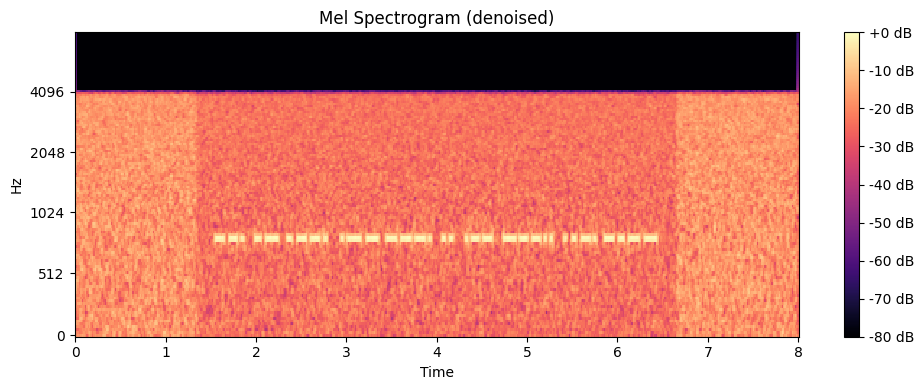

data_generated/morse_data/audio/2.opus


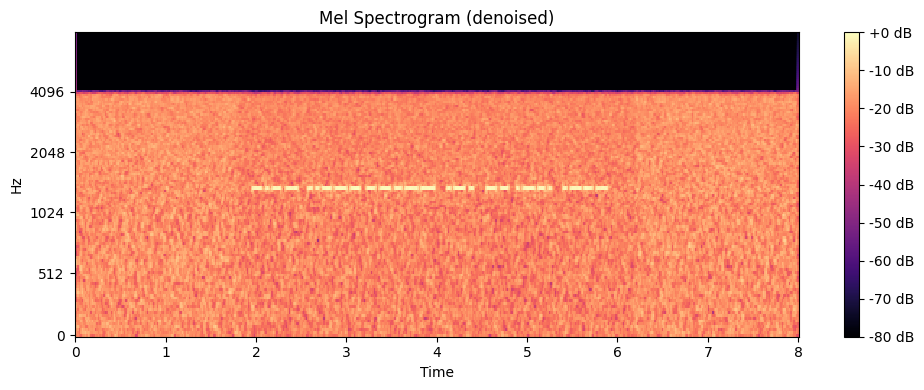

In [50]:
for i in path_to_files_from_n_to_m(1, 3, base_path="data_generated/morse_data/audio/"):
    print(i)
    y, sr = open_file(i)
    S_db = get_mell(y, sr)
    
    # r = process_morse_audio(i, visualize=False)
    # S_db = r['spectrogram']
    # sr = r['sr']
    draw_mell(S_db, sr)

### Аугментация 

In [ ]:
SOURCE_DIR = 'D:/pypy/kontur/data/morse_dataset/morse_dataset'
DEST_DIR = 'morse_data/audio'
os.makedirs(DEST_DIR, exist_ok=True)

# Исходный датасет
df = pd.read_csv('D:/pypy/kontur/data/train.csv')

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=9, p=0.9),
    Gain(min_gain_db=-6.0, max_gain_db=6.0, p=0.7),
    Shift(min_shift=-0.08, max_shift=0.08, p=0.5),
    BandPassFilter(min_center_freq=300, max_center_freq=3000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.0, p=0.2),
    ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=20, p=0.4),
    # TimeMask(min_band_part=0.001, max_band_part=0.005, p=0.3)  
])
#  Список новых записей
augmented_records = []

# Цикл по строкам train.csv
for idx, row in df.iterrows():
    file_id = row["id"]
    label = row["message"]
    orig_path = os.path.join(SOURCE_DIR, f"{file_id}")

    try:
        samples, sr = librosa.load(orig_path, sr=None)
    except Exception as e:
        print(f"Error loading {orig_path}: {e}")
        continue

    # Аугментация
    augmented_samples = augment(samples=samples, sample_rate=sr)

    # Генерация нового ID (без расширения)
    new_file_id = f"{file_id}"
    new_filename = f"{new_file_id}"
    new_file_path = os.path.join(DEST_DIR, new_filename)

    try:
        sf.write(new_file_path, augmented_samples, sr, format='OGG', subtype='OPUS')
    except Exception as e:
        print(f"Error saving {new_file_path}: {e}")
        continue

    # Добавление строки в metadata
    augmented_records.append({
        "id": new_file_id,  # без .opus
        "message": label
    })

    if idx % 100 == 0:
        print(f"Processed {idx}/{len(df)}")
        # break

# Сохраняем метаданные
aug_df = pd.DataFrame(augmented_records)
aug_df.to_csv('morse_data/metadata.csv', index=False)
print(" Аугментированные данные сохранены.")


Создание датасета

Ген спектрограмма: torch.Size([1, 128, 501])
Спектрограмма: torch.Size([1, 128, 501])
Метка (индексы): tensor([34, 37, 27, 21, 29, 13, 17, 10,  4, 23])
Метка (символы): 03ЩУЫЛПИГХ


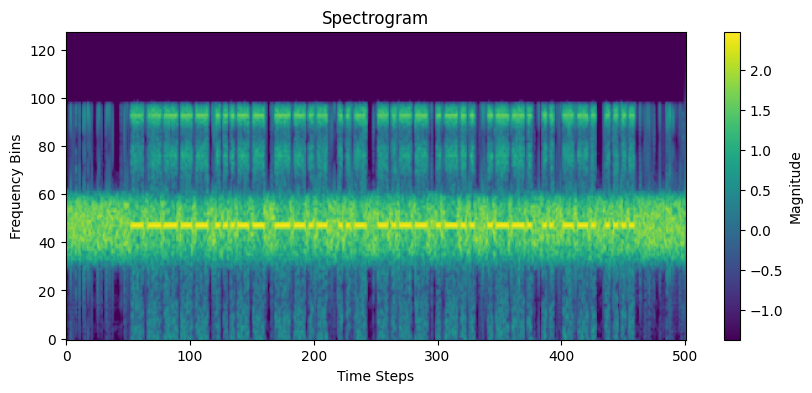

In [51]:
df = pd.read_csv('data/train.csv')
dataset = MorseDataset(df, 'data/morse_dataset/morse_dataset')

df_generated = pd.read_csv('data_generated/morse_data/metadata.csv')
dataset_genearated = MorseDataset(df_generated, 'data_generated/morse_data/audio')

df_augmented = pd.read_csv('data_augmented/morse_data/metadata.csv')
dataset_augmented = MorseDataset(df_augmented, 'data_augmented/morse_data/audio')

combined_dataset = ConcatDataset([dataset, dataset_augmented, dataset_genearated])

spectrogram, label = dataset[0]

spectrogram_gen, label_gen = dataset_genearated[30]

print('Ген спектрограмма:', spectrogram_gen.shape)
print("Спектрограмма:", spectrogram.shape)
print("Метка (индексы):", label)
print("Метка (символы):", ''.join([INDEX_TO_CHAR[i.item()] for i in label]))

# Рисуем спектрограмму
spectrogram = spectrogram.squeeze(0) 
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')

# Добавляем подписи к осям
plt.title('Spectrogram')
plt.xlabel('Time Steps')
plt.ylabel('Frequency Bins')

# Добавляем цветовую шкалу
plt.colorbar(label='Magnitude')

# Показываем график
plt.show()

### Архитектура.
Эксперементальным путем лучше всего себя показала CRNN  
CNN + BiLSTM  

Для входа [1, 128, 501]:

После CNN:

Conv1 + MaxPool(2,2) → [32, 64, 250]

Conv2 + MaxPool(2,2) → [64, 32, 125]

Conv3 + MaxPool(2,1) → [128, 16, 125] (сохраняем временную длину)

Перед BiLSTM:

reshape → [batch, 125, 128*16] = [batch, 125, 2048]

После BiLSTM:

[batch, 125, 512] (при hidden_size=256)

In [52]:
class MorseCRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256, cnn_out_channels=128, dropout_cnn=0.2, dropout_rnn=0.3, dropout_fc=0.35):
        super().__init__()
        
        # CNN часть (оптимизирована для вашей спектрограммы)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_cnn),
            nn.MaxPool2d(2, 2),  # [32, 64, 250]
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout2d(dropout_cnn),
            nn.MaxPool2d(2, 2),  # [64, 32, 125]
            
            nn.Conv2d(64, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
            nn.Dropout2d(dropout_cnn),
            nn.MaxPool2d((2, 1), stride=(2, 1))  # [128, 16, 125] (сохраняем временную длину)
        )
        
        # RNN часть (BiLSTM)
        self.rnn = nn.LSTM(
            input_size=cnn_out_channels * 16,  # После CNN height=16
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rnn 
        )
        
        self.dropout_fc = nn.Dropout(dropout_fc)
        # Классификатор
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 для bidirectional

    def forward(self, x):
        # x: [batch, 1, 128, 501]
        x = self.cnn(x)  # [batch, 128, 16, 125]
        
        # Подготовка для RNN
        batch, channels, height, time = x.size()
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, height]
        x = x.reshape(batch, time, channels * height)  # [batch, time, features]
        
        # RNN
        x, _ = self.rnn(x)  # [batch, time, hidden_size*2]
        
        
        # Дополнительный Dropout перед классификацией
        x = self.dropout_fc(x)
        
        # Классификация
        x = self.fc(x)  # [batch, time, num_classes]
        return F.log_softmax(x, dim=2)
    
    def cnn_output_length(self, input_length):
        """Вычисляет длину временной оси после всех CNN слоев"""
        length = input_length
        for layer in self.cnn:
            if isinstance(layer, nn.Conv2d):
                # Для Conv2d с padding=1 и stride=1 длина не меняется
                pass
            elif isinstance(layer, nn.MaxPool2d):
                # Для MaxPool2d применяем целочисленное деление
                kernel_size = layer.kernel_size
                stride = layer.stride
                if isinstance(kernel_size, int):
                    kernel_size = (kernel_size, kernel_size)
                if isinstance(stride, int):
                    stride = (stride, stride)
                length = length // stride[1]  # Делим по временной оси
        return length

In [53]:
def train(model, dataset, device, epochs=10, batch_size=32, final_fit=False,
          early_stopping_patience=5, model_path="best_model_3.pt"):
    """
    Обучает модель на заданном наборе данных с возможностью ранней остановки и сохранения лучшей модели.
    Args:
        model Модель Pytorch
        dataset Dataset Pytorch для обучения
        device cuda или cpu
        epochs кол-во эпох (10)
        batch_size размер батча (32)
        final_fit (bool): Флаг, указывающий, следует ли использовать весь набор данных для обучения без валидации.
        early_stopping_patience: склько эпох без улучшения до тригера остановки
        model_path: Куда сохранять веса лучшей модели    
    Описание:
        - Если final_fit=False, данные разделяются на обучающую и валидационную выборки (80/20).
        - Для обучения используется оптимизатор AdamW и функция потерь CTCLoss.
        - Поддерживается ранняя остановка (early stopping) на основе валидационной ошибки.
        - Лучшая модель сохраняется в файл, указанный в model_path.
        - Если final_fit=True, используется весь набор данных для обучения без валидации.
    """
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CTCLoss(blank=0)

    # Разделение train/val, если не финальное обучение
    if not final_fit:
        val_size = int(0.2 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    else:
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = None

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f"Train {epoch+1}")
        for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in progress_bar:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            outputs = model(spectrograms)
            outputs = outputs.permute(1, 0, 2)

            cnn_time = model.cnn_output_length(input_lengths)
            loss = criterion(outputs, labels, cnn_time, label_lengths)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)

            progress_bar.set_postfix({
                "Train Loss": f"{avg_loss:.4f}",
                "LR": f"{optimizer.param_groups[0]['lr']:.2e}"
            })

        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for spectrograms, labels, input_lengths, label_lengths in val_loader:
                    spectrograms = spectrograms.to(device)
                    labels = labels.to(device)

                    outputs = model(spectrograms)
                    outputs = outputs.permute(1, 0, 2)

                    cnn_time = model.cnn_output_length(input_lengths)
                    loss = criterion(outputs, labels, cnn_time, label_lengths)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f}")

            # Early Stopping Check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), model_path)
                print(f"New best model saved with val loss: {best_val_loss:.4f}")
            else:
                patience_counter += 1
                print(f"No improvement ({patience_counter}/{early_stopping_patience})")

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    print("\nTraining completed!")
    if os.path.exists(model_path):
        print(f"Best model saved at: {model_path}")


In [54]:
def predict(model, file_path, device):
    """
    Выполняет предсказание текста из аудиофайла с использованием обученной модели.
    Args:
        model: Обученная модель PyTorch.
        file_path: Путь к аудиофайлу для предсказания.
        device Устройство для выполнения вычислений (например, 'cuda' или 'cpu').

    Returns:
        str: Расшифрованный текст из аудиофайла.

    Описание:
        - Функция загружает аудиофайл преобразует его в спектрограмму и нормализует данные.
        - Спектрограмма подается в модель для получения предсказаний.
        - Для декодирования используется greedy decoding с удалением повторяющихся символов и blank-токенов.
    """
    model.eval()
    model.to(device)
    
    # Шаг 1: Загрузить аудио и получить спектрограмму
    y, sr = open_file(file_path)
    S_dB = torch.from_numpy(get_mell(y, sr))  # (n_mels, time)
    S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
    spectrogram = S_dB.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, n_mels, time]
    
    # Шаг 2: Прогнать через модель
    with torch.no_grad():
        output = model(spectrogram)  # [1, time, num_classes]
        output = output.permute(1, 0, 2)  # [time, 1, num_classes]
    
    # Шаг 3: Greedy decoding (CTC)
    predicted_indices = torch.argmax(output, dim=2).squeeze(1)  # [time]
    
    # Удаляем повторяющиеся символы и blank'и (0)
    prev = -1
    decoded = []
    for idx in predicted_indices:
        idx = idx.item()
        if idx != prev and idx != 0:  # 0 — это blank
            decoded.append(INDEX_TO_CHAR[idx])
        prev = idx

    return ''.join(decoded)

Обучение

In [55]:
model = MorseCRNN(num_classes=len(CHAR_TO_INDEX))
print(f"Параметров: {sum(p.numel() for p in model.parameters()):,}")

Параметров: 6,416,366


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train(model, combined_dataset, device, epochs=30, early_stopping_patience=3, final_fit=False)

Предсказания

In [ ]:
# Загрузить веса если надо 
# model = MorseCRNN(num_classes=len(CHAR_TO_INDEX))
# model.load_state_dict(torch.load("model_path.pt"))

In [ ]:
df = pd.read_csv("data/test.csv")

# Готовим список предсказаний
predictions = []

# Проходим по всем файлам
k = 0
for filename in tqdm(df["id"]):
    full_path = f"data/morse_dataset/morse_dataset/{filename}"
    try:
        # prediction = predict_with_preprocessing(model, full_path, device)
        prediction = predict(model, full_path, device)
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {e}")
        prediction = ""
    predictions.append(prediction)

# Добавляем колонку с предсказаниями
df["message"] = predictions

# Сохраняем в submission.csv
df.to_csv("submission_3.csv", index=False)

print("Предсказания сохранены в submission_3.csv")

##### задание со звёздочкой.  
- При ручной проверке я заметил, что модель в целом правильно выписывает морзе из файла, но потом выдумывает из остатка шума еще буквы. Даже по 2-5 букв это достаточно сильный удар по точности.  
- Так что хорошим решением будет просто обрезать лишний звук из файла. 

In [ ]:
def auto_trim(y, sr, db_range=range(9, 31), margin_sec=1.0):
    """
    Автоматически подбирает top_db и возвращает сигнал с запасом по краям.
    
    :param y: аудиосигнал
    :param sr: sample rate
    :param db_range: диапазон перебора top_db (например, range(13, 31))
    :param margin_sec: запас в секундах с каждой стороны
    :return: обрезанный сигнал
    """
    lengths = []
    trims = []

    # Пробуем обрезку при разных top_db
    for top_db in db_range:
        y_trimmed, (start, end) = librosa.effects.trim(y, top_db=top_db)
        length = end - start
        lengths.append(length)
        trims.append((start, end))

    # Находим топ_db, при котором длина почти не растёт
    diffs = np.diff(lengths)
    stable_idx = np.argmax(diffs <= 1000)  
    if stable_idx == 0:
        best_idx = 0
    else:
        best_idx = stable_idx - 1

    start, end = trims[best_idx]

    # Добавляем margin
    margin = int(sr // 2 * margin_sec)
    new_start = max(0, start - margin)
    new_end = min(len(y), end + margin)

    return y[new_start:new_end], db_range[best_idx]

In [ ]:
def predict_last(model, file_path, device):
    """
    Отдельный предикт для последних 17 файлов с автоматической обрезкой длины по сигналу
    """
    model.eval()
    model.to(device)
    
    # Шаг 1: Загрузить аудио и получить спектрограмму
    y, sr = open_file(file_path)
    y, used_db = auto_trim(y, sr)
    S_dB = torch.from_numpy(get_mell(y, sr))  # (n_mels, time)
    S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
    spectrogram = S_dB.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, n_mels, time]
    
    # Шаг 2: Прогнать через модель
    with torch.no_grad():
        output = model(spectrogram)  # [1, time, num_classes]
        output = output.permute(1, 0, 2)  # [time, 1, num_classes]
    
    # Шаг 3: Greedy decoding (CTC)
    predicted_indices = torch.argmax(output, dim=2).squeeze(1)  # [time]
    
    # Удаляем повторяющиеся символы и blank'и (0)
    prev = -1
    decoded = []
    for idx in predicted_indices:
        idx = idx.item()
        if idx != prev and idx != 0:  # 0 — это blank
            decoded.append(INDEX_TO_CHAR[idx])
        prev = idx

    return ''.join(decoded)

In [ ]:
df = pd.read_csv('submission_3.csv')

for i in path_to_files_from_n_to_m(34984, 35001):
    prediction = predict_last(model, i, device)
    id = i.split('/')[-1]
    df.loc[df['id'] == id, 'message'] = prediction

df.to_csv("submission_3_last.csv", index=False)  

Получилсь, немного обидно, потому что я подумал что не надо вставлять в сабмит расшифрованное сообщение.

Так бы может был бы не 17 с 0.41 а в топ 5 с 0.28 каким нибудь

Но вот текст, который получился поменяв проходом по словарю с алафавитом 

`ВНИМАНИЕ ВСЕМ КОЛОНИЯМ  МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИ ПЕРЕЖИЛА ВЕЛИКУЮ ТЬМУ  НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН  МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАГОМ       ТЕПЕРЬ ВОЦАРИЛСЯ МИР  РАСПРИ ОСТАЛИСЬ ПОЗАДИ  МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ ВЫГОД И ЖЕЛАНИЙ  МЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЕЛЕГРАФА  НО НЕ МОЖЕМ РУЧАТЬСЯ ЗА АБСОЛЮТНУЮ ВЕРНОСТЬ СИМВОЛОВ  ЕСЛИ ВЫ СЛЫШИТЕ   ТО ПОСЛАНИЕ ТО ОТКЛИКНИТЕСЬ  НА ЧАСТОТЕ ПЕРЕДАЧИ УВЕЛИЧЕННОЙ НА 20 КИЛОЦИКЛОВ  СВЯЗЬ ПОДДЕРЖИВАЕТСЯ ВРУЧНУЮ НЕУТОМИМЫМИ ПАЛЬЦАМИ НАШИХ ОПЕРАТОРОВ  СКОРО МЫ ВНОВЬ ПОСТИГНЕМ ТАЙНЫ РАКЕТНЫХ ДВИГАТЕЛЕЙ  СМОЖЕМ ОТПРАВИТЬ ЗА ВАМИ СПАСИТЕЛЬНЫЙ ЧЕЛНОК  ЕСЛИ ВЫ ПОЖЕЛАЕТЕ ВЕРНУТЬСЯ ДОМОЙ АА  СВЕТ СОЛНЦА ДАРИТ ЖИЗНЬ КАЖДОМУ  КОНЕЦ ПЕРЕДАЧИ`

In [61]:
rus_to_morse = {
    'А': '.-', 'Б': '-...', 'В': '.--', 'Г': '--.', 'Д': '-..',
    'Е': '.', 'Ж': '...-', 'З': '--..', 'И': '..', 'Й': '.---',
    'К': '-.-', 'Л': '.-..', 'М': '--', 'Н': '-.', 'О': '---',
    'П': '.--.', 'Р': '.-.', 'С': '...', 'Т': '-', 'У': '..-',
    'Ф': '..-.', 'Х': '....', 'Ц': '-.-.', 'Ч': '---.', 'Ш': '----',
    'Щ': '--.-', 'Ъ': '.--.-.', 'Ы': '-.--', 'Ь': '-..-', 'Э': '..-..',
    'Ю': '..--', 'Я': '.-.-', 'Ё': '.', ' ': '/'
}

# Обратный словарь
morse_to_rus = {v: k for k, v in rus_to_morse.items()}

def text_to_morse(text):
    return ' '.join(rus_to_morse.get(char, '') for char in text)

def invert_morse(morse_code):
    return ''.join('-' if c == '.' else '.' if c == '-' else c for c in morse_code)

def morse_to_text(morse_code):
    return ''.join(morse_to_rus.get(code, '?') for code in morse_code.split())

df['morse'] = df['message'].apply(lambda x: text_to_morse(x))
df['inverted_morse'] = df['morse'].apply(invert_morse)
df['inverted_text'] = df['inverted_morse'].apply(morse_to_text)

# Показать результат
display(df[['id', 'message', 'inverted_text']].tail(17))

,id,message,inverted_text
4983,34984.opus,ДАМИНАМТ ДОТИ РСЫСАМЦИ,ВНИМАНИЁ ВСЁМ КОЛОНИЯМ
4984,34985.opus,ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТКТЧМЫН ДТЫ...,МЫ ПОДТВЁРЖДАЁМ ЦИВИЛИЗАЦИЯ ЗЁМЛИ ПЁРЁЖИЛА ВЁЛ...
4985,34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА,НАШ ДОСТУП К ДРЁВНИМ АРХИВАМ УТРАЧЁН
4986,34987.opus,ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНУСИ,МЫ ВНОВЬ ПОСТИГАЁМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАГОМ
4987,34988.opus,ЕТЬТКП ДСЯНКМЫОЦ ИМК,ТЁПЁРЬ ВОЦАРИЛСЯ МИР
4988,34989.opus,КНОЬКМ СОЕНЫМОП ЬСЮНВМ,РАСПРИ ОСТАЛИСЬ ПОЗАДИ
4989,34990.opus,ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУ...,МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЁГО ПРЁВЫШЁ ЛИЧНЫХ ВЫГ...
4990,34991.opus,ИЛ ДАСДП ОСЮВНЫМ НЮЙГРГ ЕТЫТУКНЩН ЕРЪРЛ4ЪС2О67...,МЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЁЛЁГРАФА ТК?КЫ?ОСЁШ?РН
4991,34992.opus,АС АТ ИСЧТИ КГЖНЕПОЦ ЮН НЙОСЫЗЕАЧЗ ДТКАСОЕП ОМ...,НО НЁ МОЖЁМ РУЧАТЬСЯ ЗА АБСОЛЮТНЖЮ ВЁРНОСТЬ СИ...
4992,34993.opus,ТОЫМ ДЛ ОЫЛХМЕТ #ЕС ЬСОЫНАМТ ЕС СЕРЫМРАМЕТОП,ЁСЛИ ВЫ СЛЫШИТЁ ТО ПОСЛАНИЁ ТО ОТКЛИКНИТЁСЬ


## Спасибо за внимание